galとexについてpredict

## 変更
新しい特徴量  
'flux_ratio_sq':['sum','skew'],
'flux_by_flux_ratio_sq':['sum','skew'],
agg_train['flux_diff'] = agg_train['flux_max'] - agg_train['flux_min']
agg_train['flux_dif2'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_mean']
agg_train['flux_w_mean'] = agg_train['flux_by_flux_ratio_sq_sum'] / agg_train['flux_ratio_sq_sum']
agg_train['flux_dif3'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_w_mean'] 

なんか分けたあともredshift系は有効なんやね
hostgal_photoz, err

最初のdetectedと最後のdetectedの差

## 結果

gal 0.04383781628138259
ex 0.8355550553747745

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
import itertools
import pickle, gzip
import glob
import importlib
import time
import warnings
from joblib import dump, load

from cv_sampler import *

np.warnings.filterwarnings('ignore')


In [2]:
import load_data
importlib.reload(load_data)

<module 'load_data' from '/mnt/disks/disk-1/project/new-lsst/scripts/load_data.py'>

In [ ]:
import submit

In [4]:
raw_train_df = pd.read_csv('../input/training_set.csv')

In [5]:
train = raw_train_df.copy()
detected_groups = train[train['detected'] == 1].groupby('object_id')
detected_length = detected_groups['mjd'].max() - detected_groups['mjd'].min()
del train

In [6]:
%%time
df = raw_train_df.copy()

df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']

flux_all_dict = {
    "flux": ["min", "max", "mean", "median", "std", "skew"],
    "flux_err": ['min', 'max', 'mean', 'median', 'std','skew'],
    "detected": ["mean"],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew']
}

flux_all_feats = df.groupby('object_id').agg(flux_all_dict)
new_columns = [
    k + '_' + agg for k in flux_all_dict.keys() for agg in flux_all_dict[k]
]
flux_all_feats.columns = new_columns

flux_all_feats['detected_length'] = detected_length
del detected_length

flux_kurt = df.groupby('object_id').flux.apply(lambda x: x.kurtosis())
flux_all_feats['flux_kurtosis'] = flux_kurt

flux_all_feats[
    'flux_diff'] = flux_all_feats['flux_max'] - flux_all_feats['flux_min']

flux_all_feats['flux_abs_median'] = df.groupby('object_id').flux.apply(
    lambda x: x.abs().median())

flux_all_feats['flux_diff_dbmed'] = flux_all_feats[
    'flux_diff'] / flux_all_feats['flux_abs_median']
flux_all_feats['flux_max_dbmed'] = flux_all_feats[
    'flux_max'] / flux_all_feats['flux_abs_median']
flux_all_feats['flux_min_dbmed'] = flux_all_feats[
    'flux_min'] / flux_all_feats['flux_abs_median']

flux_pb_feats = df.groupby(['object_id', 'passband']).agg({
    "flux": ["min", "max", "mean", "median", "std", "skew"],
})

flux_pb_feats.columns = [
    'flux_' + measure for measure in flux_pb_feats.columns.levels[1]
]

flux_pb_kurt = df.groupby(['object_id',
                           'passband']).flux.apply(lambda x: x.kurtosis())
flux_pb_absmed = df.groupby(
    ['object_id', 'passband']).flux.apply(lambda x: x.abs().median())

concat_pd_feats = pd.concat([
    flux_pb_feats,
    pd.DataFrame({
        'flux_kurt': flux_pb_kurt
    }),
    pd.DataFrame({
        'flux_absmed': flux_pb_absmed
    })
],
                            axis=1)

concat_pd_feats["flux_diff"] = concat_pd_feats[
    "flux_max"] - concat_pd_feats["flux_min"]
concat_pd_feats["flux_diff_dbmed"] = concat_pd_feats[
    "flux_diff"] / concat_pd_feats['flux_absmed']
concat_pd_feats["flux_max_dbmed"] = concat_pd_feats[
    "flux_max"] / concat_pd_feats['flux_absmed']
concat_pd_feats["flux_min_dbmed"] = concat_pd_feats[
    "flux_min"] / concat_pd_feats['flux_absmed']

flat_concat_pd_feats = concat_pd_feats.unstack()
flat_concat_pd_feats.columns = [
    key + "_" + str(pb) for key in flat_concat_pd_feats.columns.levels[0]
    for pb in flat_concat_pd_feats.columns.levels[1]
]

train_feature_df = pd.concat([flux_all_feats, flat_concat_pd_feats], axis=1)


CPU times: user 35 s, sys: 225 ms, total: 35.3 s
Wall time: 30 s


In [7]:
period_df = load_data.load_train_period()

concat_df = pd.concat([train_feature_df, period_df], axis=1)
meta_data = pd.read_csv('../input/training_set_metadata.csv')
meta_data.index = meta_data.object_id

meta_concat_df = pd.concat([concat_df, meta_data[['hostgal_photoz', 'hostgal_photoz_err']]], axis=1)

meta_concat_df.fillna(meta_concat_df.mean(), inplace=True)

In [8]:
gal_df, ex_df = load_data.cut_galaxy(meta_concat_df, meta_data)
gal_target, ex_target = load_data.cut_galaxy(meta_data.target, meta_data)

In [9]:
gal_class_weight, gal_sample_weights, gal_target_i = load_data.get_weights(gal_target)

0 Wed Dec 12 21:42:50 2018
10 Wed Dec 12 21:43:19 2018
20 Wed Dec 12 21:43:44 2018
30 Wed Dec 12 21:44:15 2018
40 Wed Dec 12 21:44:57 2018
50 Wed Dec 12 21:45:24 2018
60 Wed Dec 12 21:45:43 2018
70 Wed Dec 12 21:46:09 2018
80 Wed Dec 12 21:46:32 2018
90 Wed Dec 12 21:46:54 2018
0.04383781628138259
{'boosting_type': 'gbdt', 'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'class_weight': {0: 1, 1: 1, 2: 1, 3: 1, 4: 1}, 'learning_rate': 0.08333696521030697, 'subsample': 0.9711442893039105, 'colsample_bytree': 0.3968776788799543, 'reg_alpha': 0.0030502400724053916, 'reg_lambda': 0.009079269614095026, 'min_split_gain': 0.026960172557732715, 'min_child_weight': 1.0832479998978026, 'min_child_samples': 33, 'n_estimators': 1432, 'max_depth': 2, 'num_leaves': 89, 'silent': True, 'n_jobs': -1}
[231, 352, 293]


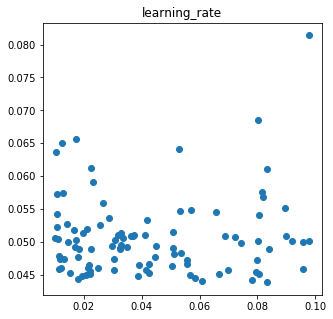

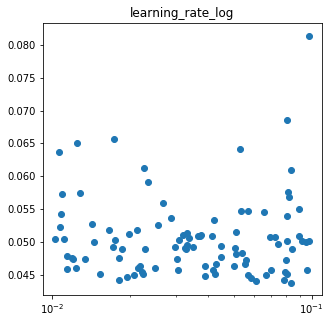

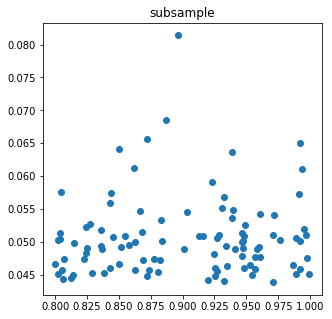

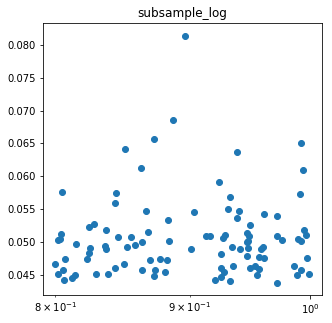

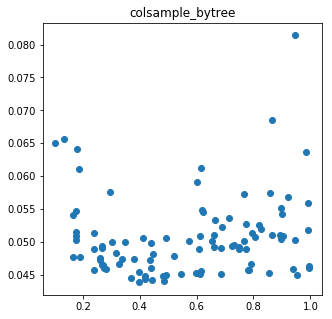

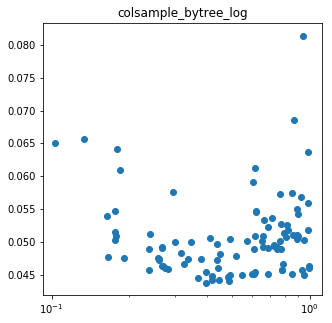

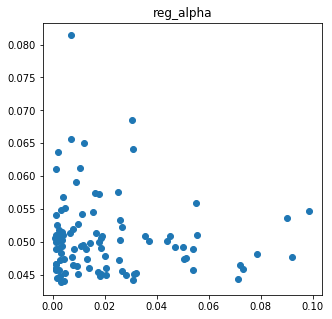

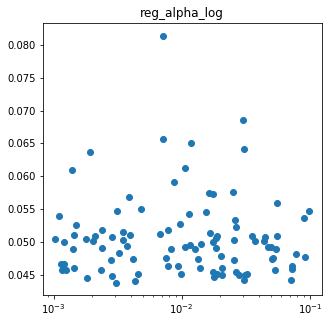

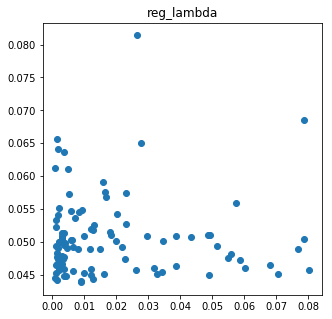

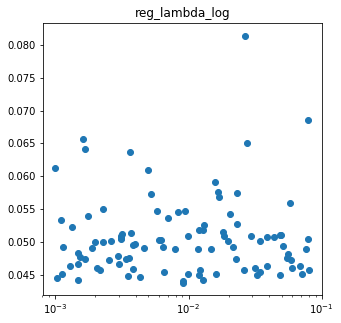

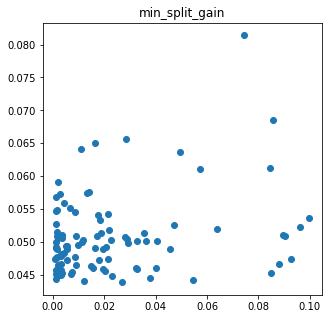

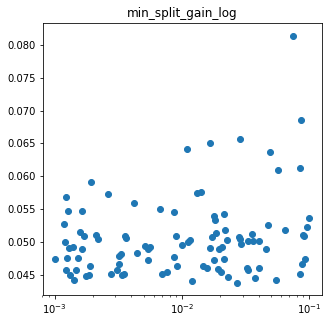

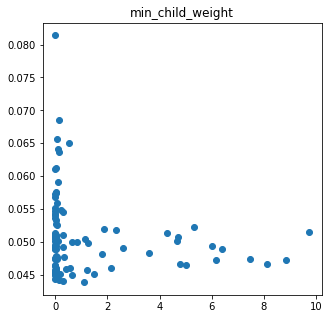

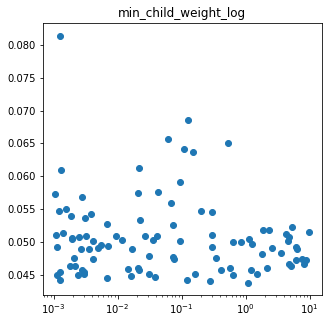

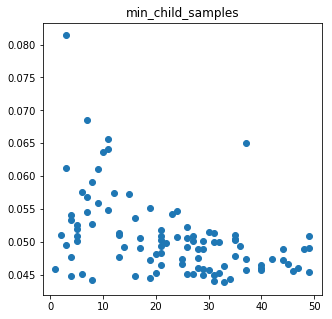

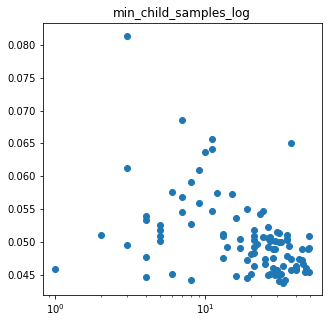

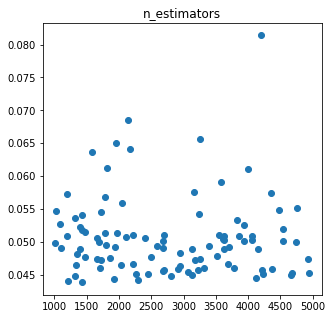

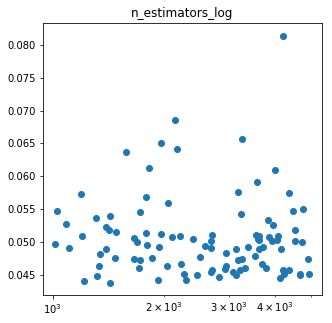

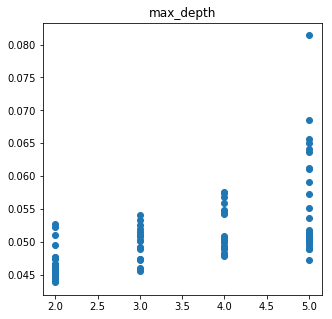

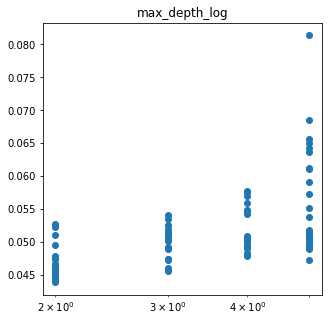

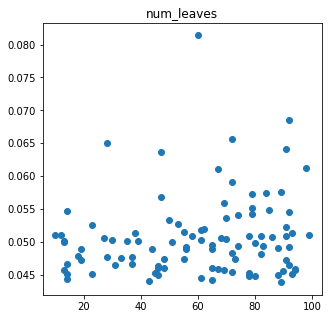

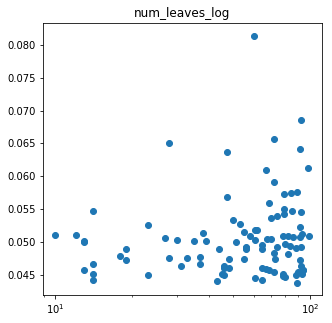

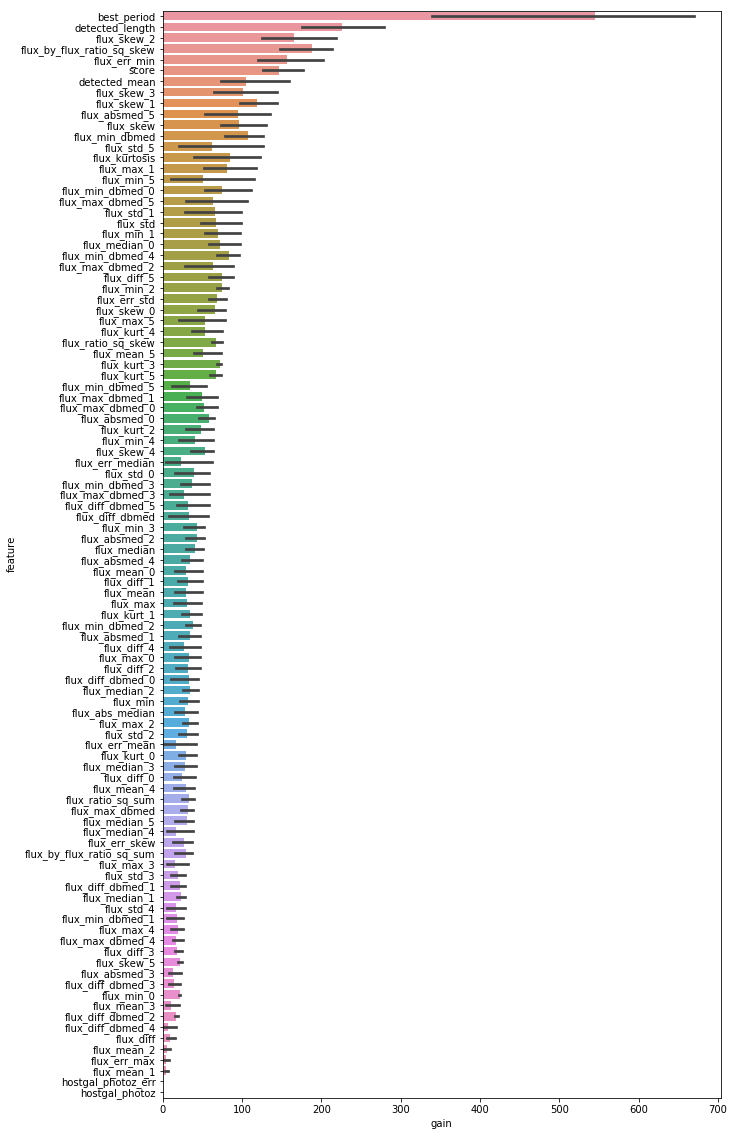

In [11]:
param_samplers = {
    'learning_rate': LogUniformSampler(-2, -1),
    'subsample': UniformSampler(0.8, 1),
    'colsample_bytree': UniformSampler(0.1, 1.0),
    'reg_alpha': LogUniformSampler(-3, -1),
    'reg_lambda': LogUniformSampler(-3, -1),
    'min_split_gain': LogUniformSampler(-3, -1),
    'min_child_weight': LogUniformSampler(-3, 1),
    'min_child_samples': UniformSampler(1, 50, int),
    'n_estimators': UniformSampler(1000, 5000, int),
    'max_depth': UniformSampler(2, 6, int),
    'num_leaves': UniformSampler(10, 100, int),
}
 
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
param_list = []
best_iteration_list = []
score_list = []
n_seed = 100
for i_seed in range(n_seed):
    if i_seed % 10 == 0:
        print(i_seed, time.ctime())
    gal_clfs = []
    gal_importances = pd.DataFrame()
    gal_lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 5,
        'metric': 'multi_logloss',
        'class_weight': gal_class_weight,
        'learning_rate': param_samplers['learning_rate'].rvs(),
        'subsample': param_samplers['subsample'].rvs(),
        'colsample_bytree': param_samplers['colsample_bytree'].rvs(),
        'reg_alpha': param_samplers['reg_alpha'].rvs(),
        'reg_lambda': param_samplers['reg_lambda'].rvs(),
        'min_split_gain': param_samplers['min_split_gain'].rvs(),
        'min_child_weight': param_samplers['min_child_weight'].rvs(),
        'min_child_samples': param_samplers['min_child_samples'].rvs(),
        'n_estimators': param_samplers['n_estimators'].rvs(),
        'max_depth': param_samplers['max_depth'].rvs(),
        'num_leaves': param_samplers['num_leaves'].rvs(),
        'silent': True,
        'n_jobs': -1
    }
    
    param_list.append(gal_lgb_params)
    
    seed_score_list = []
    seed_early_stopping = []
    for i_fold, (trn_index, val_index) in enumerate(folds.split(gal_target_i, gal_target_i)):
        trn_x, trn_y = gal_df.iloc[trn_index], gal_target_i.iloc[trn_index]
        val_x, val_y = gal_df.iloc[val_index], gal_target_i.iloc[val_index]

        gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
        gal_clf.fit(
            trn_x, trn_y,
            sample_weight=trn_y.map(gal_sample_weights),
            eval_set=[(val_x, val_y)],
            eval_metric='multi_logloss',
            eval_class_weight=[gal_class_weight],
            verbose=False,
            early_stopping_rounds=50
        )

        imp_df = pd.DataFrame()
        imp_df['feature'] = gal_df.columns
        imp_df['gain'] = gal_clf.feature_importances_
        imp_df['seed_fold'] = i_seed * 10 + i_fold + 1
        gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)

        gal_clfs.append(gal_clf)
        
        seed_score_list.append(gal_clf.best_score_['valid_0']['multi_logloss'])
        seed_early_stopping.append(gal_clf.best_iteration_)
        
    score_list.append(np.mean(seed_score_list))
    best_iteration_list.append(seed_early_stopping)


param_keys = ['learning_rate',
  'subsample',
  'colsample_bytree',
  'reg_alpha',
  'reg_lambda',
  'min_split_gain',
  'min_child_weight',
  'min_child_samples',
  'n_estimators',
  'max_depth',
  'num_leaves']

for param_key in param_keys:
    values = [ param_dict[param_key] for param_dict in param_list]
    plt.figure(figsize=(5, 5))
    plt.title(param_key)
    plt.plot(values, score_list, 'o')
    plt.figure(figsize=(5, 5))
    plt.title(param_key+'_log')
    plt.plot(values, score_list, 'o')
    plt.xscale('log')

plt.figure(figsize=(10, 20))
sns.barplot(x='gain', y='feature', data=gal_importances.sort_values('gain', ascending=False))

best_id = np.argmin(score_list)
print(score_list[best_id])
print(param_list[best_id])
print(best_iteration_list[best_id])

0 Sat Dec 15 11:20:12 2018
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[300]	training's multi_logloss: 0.00250615	valid_1's multi_logloss: 0.0757042
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[336]	training's multi_logloss: 0.00143724	valid_1's multi_logloss: 0.0575312
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[323]	training's multi_logloss: 0.00181188	valid_1's multi_logloss: 0.0622212
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[387]	training's multi_logloss: 0.0020613	valid_1's multi_logloss: 0.0559215
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[582]	training's multi_logloss: 0.000256049	valid_1's multi_logloss: 0.0296477
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[

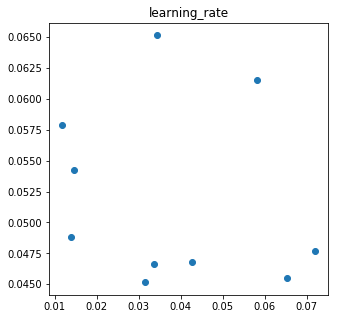

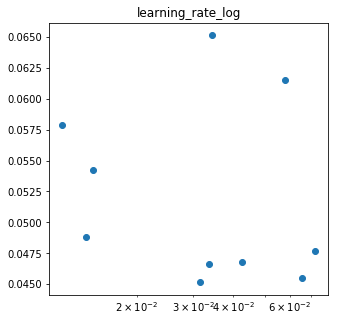

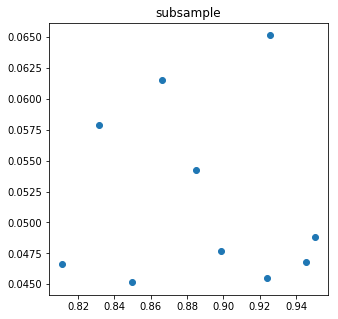

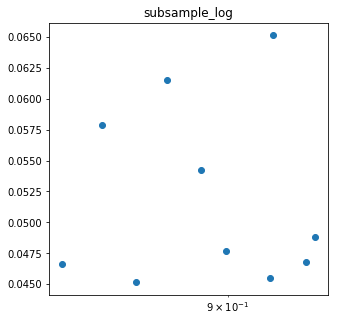

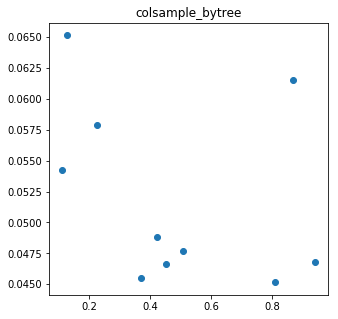

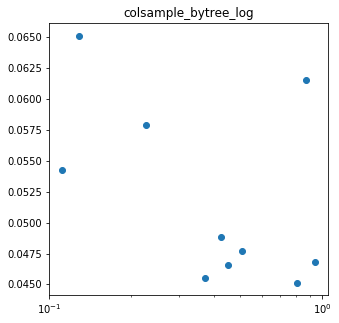

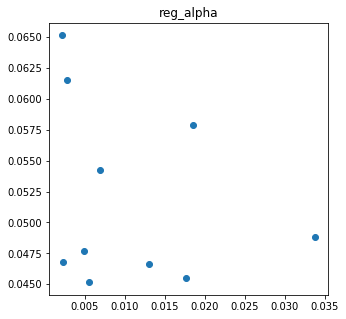

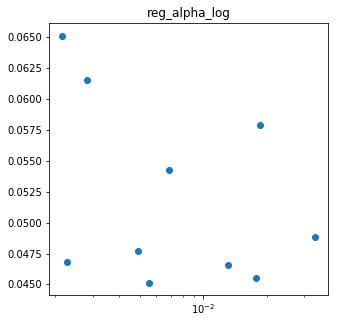

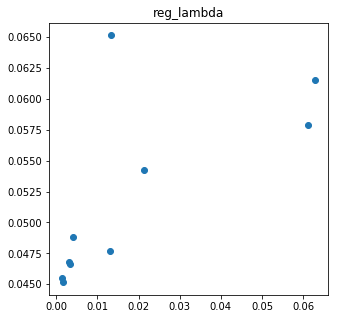

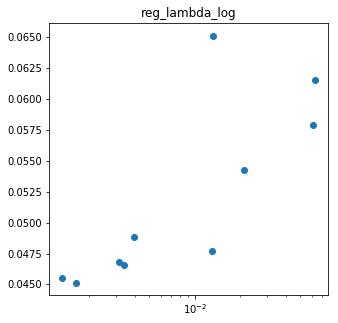

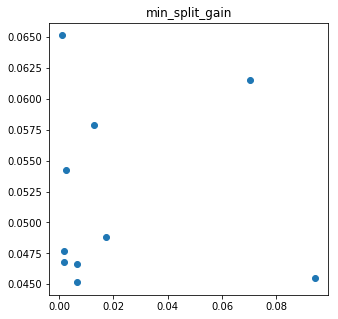

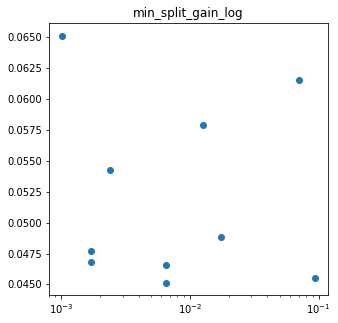

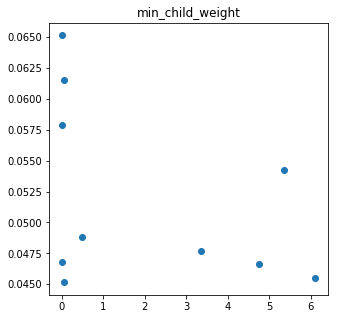

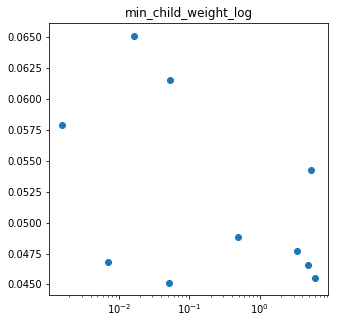

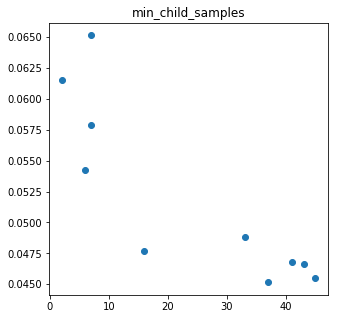

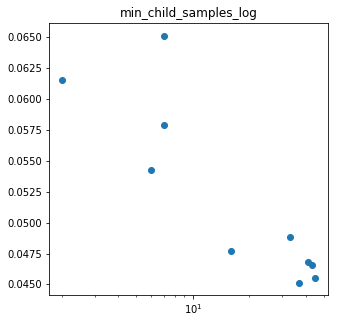

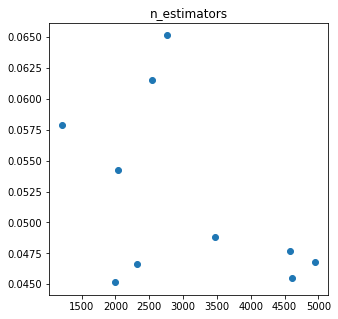

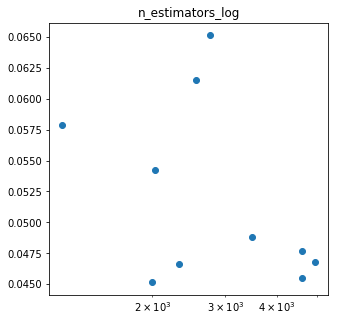

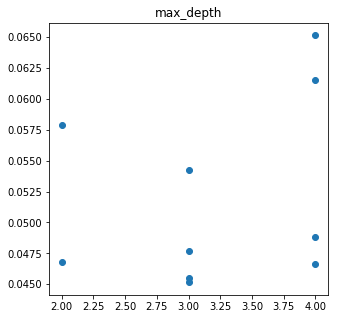

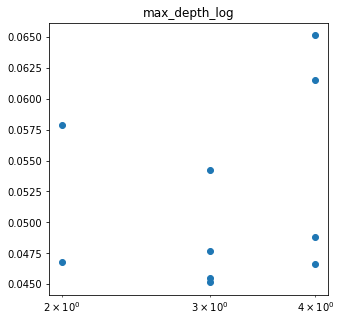

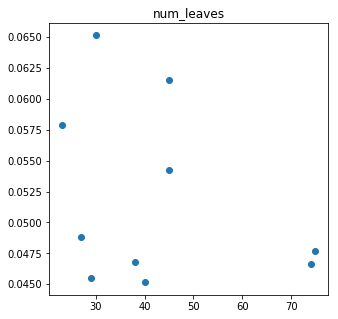

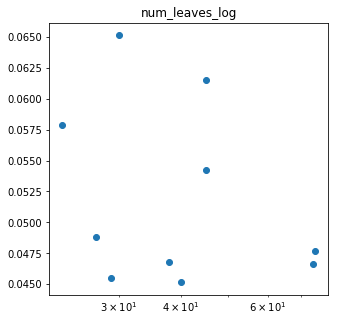

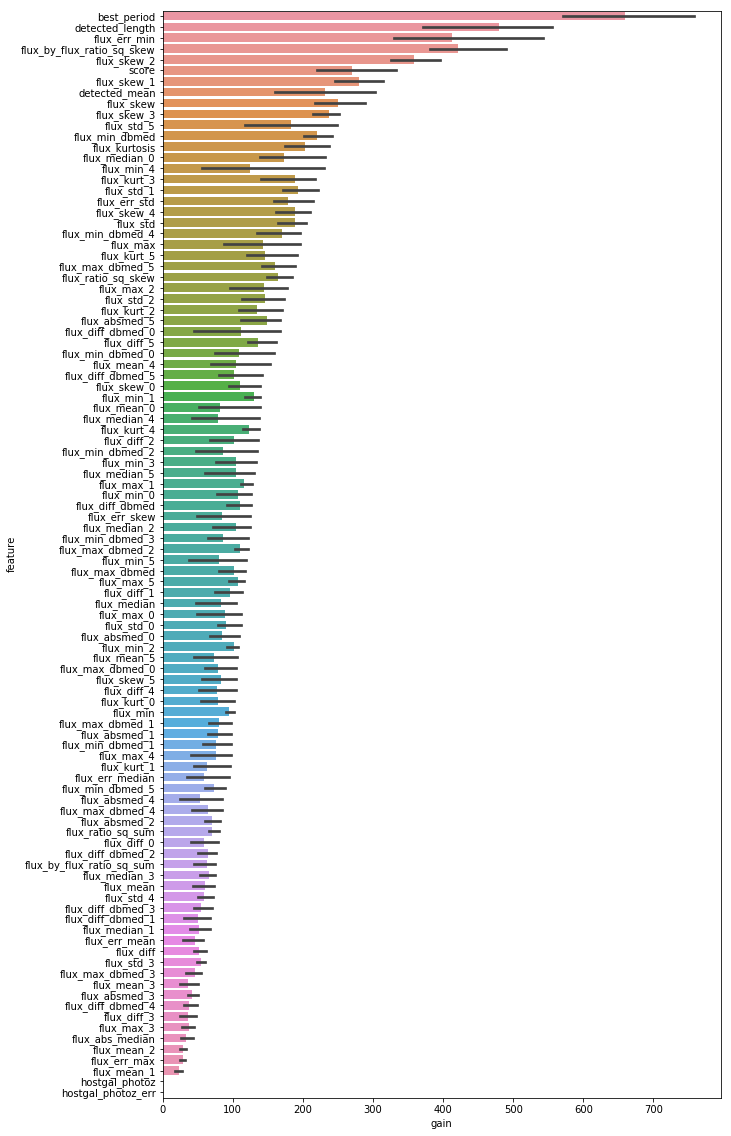

In [17]:
param_samplers = {
    'learning_rate': LogUniformSampler(-2, -1),
    'subsample': UniformSampler(0.8, 1),
    'colsample_bytree': UniformSampler(0.1, 1.0),
    'reg_alpha': LogUniformSampler(-3, -1),
    'reg_lambda': LogUniformSampler(-3, -1),
    'min_split_gain': LogUniformSampler(-3, -1),
    'min_child_weight': LogUniformSampler(-3, 1),
    'min_child_samples': UniformSampler(1, 50, int),
    'n_estimators': UniformSampler(1000, 5000, int),
    'max_depth': UniformSampler(2, 6, int),
    'num_leaves': UniformSampler(10, 100, int),
}
 
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
param_list = []
best_iteration_list = []
score_list = []
n_seed = 10
for i_seed in range(n_seed):
    if i_seed % 10 == 0:
        print(i_seed, time.ctime())
    gal_clfs = []
    gal_importances = pd.DataFrame()
    gal_lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 5,
        'metric': 'multi_logloss',
        'class_weight': gal_class_weight,
        'learning_rate': param_samplers['learning_rate'].rvs(),
        'subsample': param_samplers['subsample'].rvs(),
        'colsample_bytree': param_samplers['colsample_bytree'].rvs(),
        'reg_alpha': param_samplers['reg_alpha'].rvs(),
        'reg_lambda': param_samplers['reg_lambda'].rvs(),
        'min_split_gain': param_samplers['min_split_gain'].rvs(),
        'min_child_weight': param_samplers['min_child_weight'].rvs(),
        'min_child_samples': param_samplers['min_child_samples'].rvs(),
        'n_estimators': param_samplers['n_estimators'].rvs(),
        'max_depth': param_samplers['max_depth'].rvs(),
        'num_leaves': param_samplers['num_leaves'].rvs(),
        'silent': True,
        'n_jobs': -1
    }
    
    param_list.append(gal_lgb_params)
    
    seed_score_list = []
    seed_early_stopping = []
    for i_fold, (trn_index, val_index) in enumerate(folds.split(gal_target_i, gal_target_i)):
        trn_x, trn_y = gal_df.iloc[trn_index], gal_target_i.iloc[trn_index]
        val_x, val_y = gal_df.iloc[val_index], gal_target_i.iloc[val_index]

        gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
        gal_clf.fit(
            trn_x, trn_y,
            sample_weight=trn_y.map(gal_sample_weights),
            eval_set=[(trn_x, trn_y),(val_x, val_y)],
            eval_metric=['multi_logloss', 'multi_logloss'],
            eval_class_weight=[gal_class_weight, gal_class_weight],
            verbose=1000,
            early_stopping_rounds=50
        )

        imp_df = pd.DataFrame()
        imp_df['feature'] = gal_df.columns
        imp_df['gain'] = gal_clf.feature_importances_
        imp_df['seed_fold'] = i_seed * 10 + i_fold + 1
        gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)

        gal_clfs.append(gal_clf)
        
        seed_score_list.append(gal_clf.best_score_['valid_1']['multi_logloss'])
        seed_early_stopping.append(gal_clf.best_iteration_)
        
    score_list.append(np.mean(seed_score_list))
    best_iteration_list.append(seed_early_stopping)


param_keys = ['learning_rate',
  'subsample',
  'colsample_bytree',
  'reg_alpha',
  'reg_lambda',
  'min_split_gain',
  'min_child_weight',
  'min_child_samples',
  'n_estimators',
  'max_depth',
  'num_leaves']

for param_key in param_keys:
    values = [ param_dict[param_key] for param_dict in param_list]
    plt.figure(figsize=(5, 5))
    plt.title(param_key)
    plt.plot(values, score_list, 'o')
    plt.figure(figsize=(5, 5))
    plt.title(param_key+'_log')
    plt.plot(values, score_list, 'o')
    plt.xscale('log')

plt.figure(figsize=(10, 20))
sns.barplot(x='gain', y='feature', data=gal_importances.sort_values('gain', ascending=False))

best_id = np.argmin(score_list)
print(score_list[best_id])
print(param_list[best_id])
print(best_iteration_list[best_id])

In [16]:
gal_clf.best_score_

defaultdict(dict,
            {'training': {'multi_logloss': 0.004058339580500494},
             'valid_1': {'multi_logloss': 0.056550604375614016},
             'valid_0': {}})

In [13]:
seed_score_list

[]

In [18]:
# fit gal clf to all training
gal_importances = pd.DataFrame()
gal_lgb_params = {'boosting_type': 'gbdt', 'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'class_weight': {0: 1, 1: 1, 2: 1, 3: 1, 4: 1}, 'learning_rate': 0.08333696521030697, 'subsample': 0.9711442893039105, 'colsample_bytree': 0.3968776788799543, 'reg_alpha': 0.0030502400724053916, 'reg_lambda': 0.009079269614095026, 'min_split_gain': 0.026960172557732715, 'min_child_weight': 1.0832479998978026, 'min_child_samples': 33, 'n_estimators': 1432, 'max_depth': 2, 'num_leaves': 31, 'silent': True, 'n_jobs': -1, 'num_iteration': 293}

trn_x = gal_df
trn_y = gal_target_i
gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
gal_clf.fit(
    trn_x, trn_y,
    sample_weight=trn_y.map(gal_sample_weights),
    eval_set=[(trn_x, trn_y)],
    eval_metric='multi_logloss',
    eval_class_weight=[gal_class_weight],
    verbose=100
)

print(gal_clf.best_iteration_)

imp_df = pd.DataFrame()
imp_df['feature'] = gal_df.columns
imp_df['gain'] = gal_clf.feature_importances_
gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)


[100]	training's multi_logloss: 0.0443171
[200]	training's multi_logloss: 0.00856401
None


In [19]:
dump(gal_clf, '../models/gal_clf12201958.joblib')

['../models/gal_clf12201958.joblib']

0 Wed Dec 12 21:50:28 2018
10 Wed Dec 12 21:53:05 2018
20 Wed Dec 12 21:56:15 2018
30 Wed Dec 12 21:59:56 2018
40 Wed Dec 12 22:03:08 2018
50 Wed Dec 12 22:06:34 2018
60 Wed Dec 12 22:09:28 2018
70 Wed Dec 12 22:12:07 2018
80 Wed Dec 12 22:16:04 2018
90 Wed Dec 12 22:19:23 2018
0.8355550553747745
{'boosting_type': 'gbdt', 'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'class_weight': {0: 2, 1: 1, 2: 1, 3: 1, 4: 2, 5: 1, 6: 1, 7: 1, 8: 1}, 'learning_rate': 0.010634734235803446, 'subsample': 0.9819899290456076, 'colsample_bytree': 0.6345938439471313, 'reg_alpha': 0.006324574145686215, 'reg_lambda': 0.001647164596165583, 'min_split_gain': 0.02465357568100957, 'min_child_weight': 0.07050911333991847, 'min_child_samples': 31, 'n_estimators': 2511, 'max_depth': 18, 'num_leaves': 93, 'silent': True, 'n_jobs': -1}
[696, 740, 724]


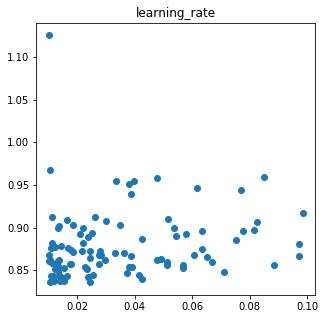

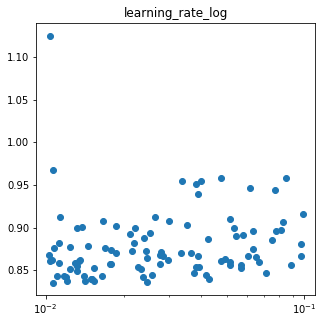

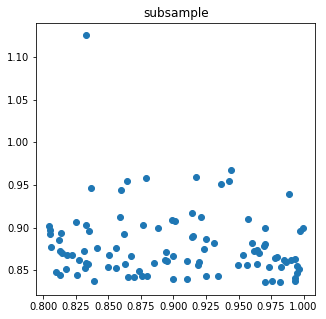

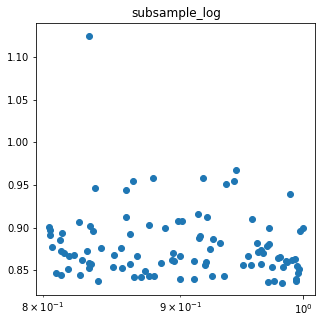

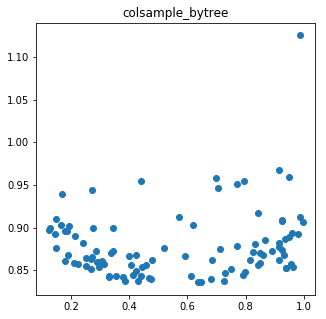

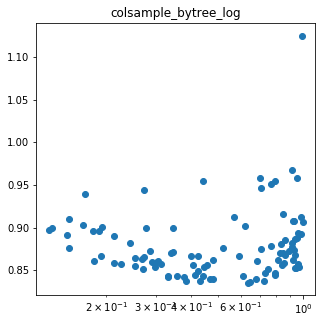

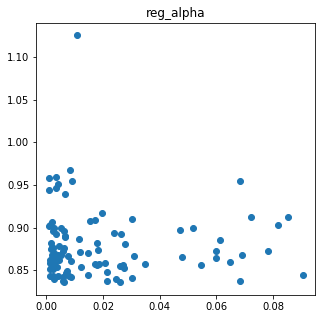

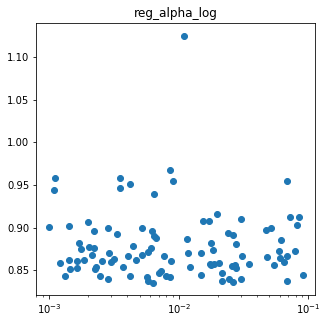

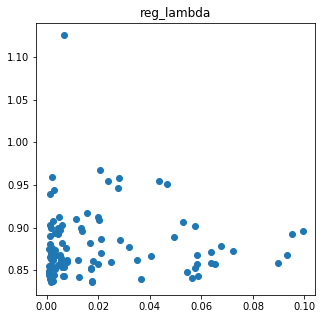

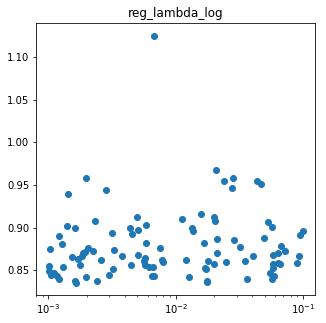

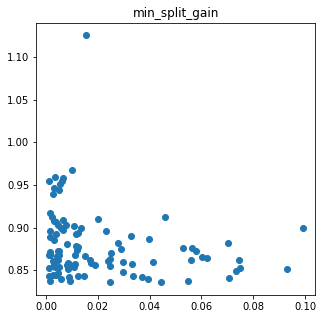

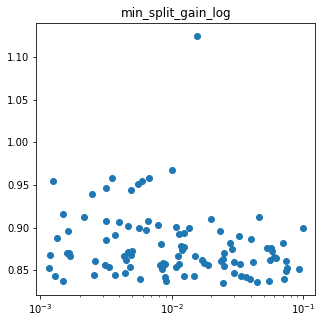

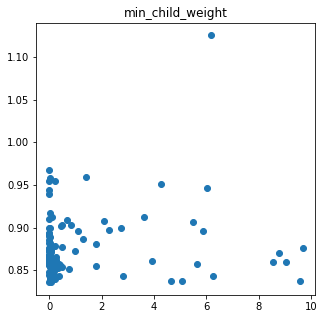

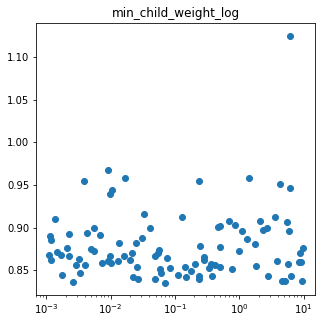

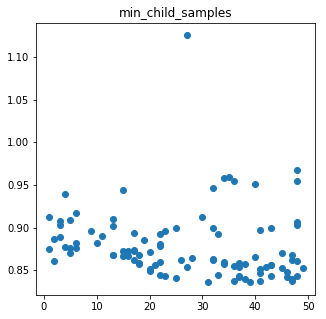

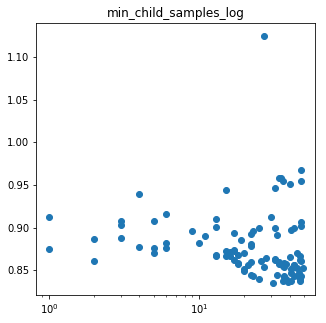

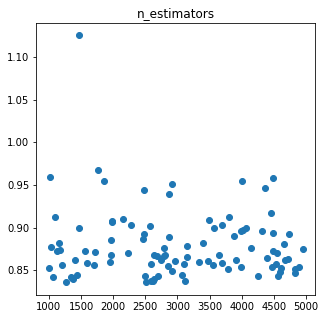

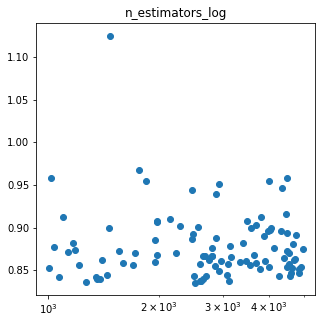

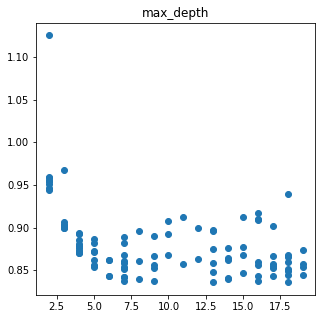

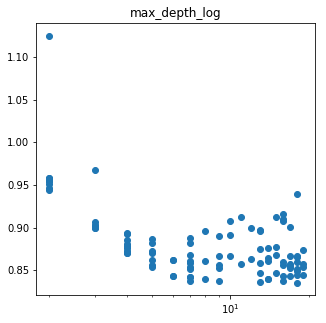

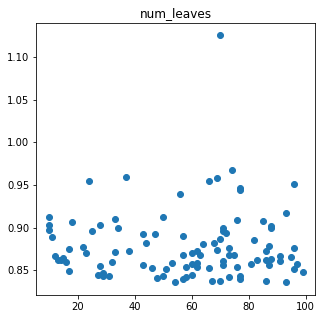

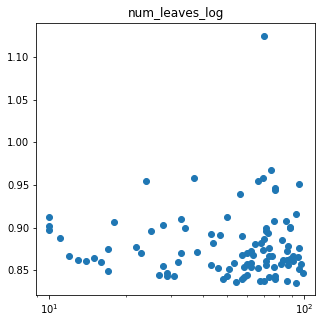

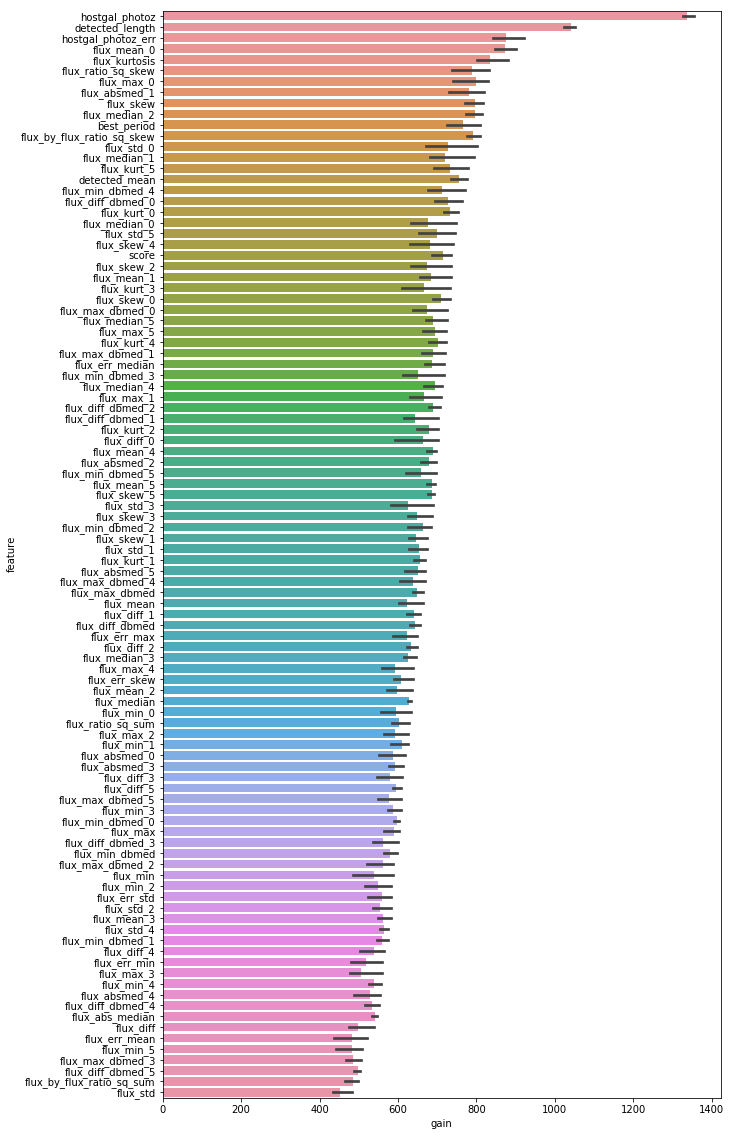

In [13]:
# param search extra galaxy
gal_df = ex_df
gal_target = ex_target
gal_class_weight, gal_sample_weights, gal_target_i = load_data.get_weights(gal_target)
param_samplers = {
    'learning_rate': LogUniformSampler(-2, -1),
    'subsample': UniformSampler(0.8, 1),
    'colsample_bytree': UniformSampler(0.1, 1.0),
    'reg_alpha': LogUniformSampler(-3, -1),
    'reg_lambda': LogUniformSampler(-3, -1),
    'min_split_gain': LogUniformSampler(-3, -1),
    'min_child_weight': LogUniformSampler(-3, 1),
    'min_child_samples': UniformSampler(1, 50, int),
    'n_estimators': UniformSampler(1000, 5000, int),
    'max_depth': UniformSampler(2, 20, int),
    'num_leaves': UniformSampler(10, 100, int),
}
 
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
param_list = []
best_iteration_list = []
score_list = []
n_seed = 100
for i_seed in range(n_seed):
    if i_seed % 10 == 0:
        print(i_seed, time.ctime())
    gal_clfs = []
    gal_importances = pd.DataFrame()
    gal_lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 5,
        'metric': 'multi_logloss',
        'class_weight': gal_class_weight,
        'learning_rate': param_samplers['learning_rate'].rvs(),
        'subsample': param_samplers['subsample'].rvs(),
        'colsample_bytree': param_samplers['colsample_bytree'].rvs(),
        'reg_alpha': param_samplers['reg_alpha'].rvs(),
        'reg_lambda': param_samplers['reg_lambda'].rvs(),
        'min_split_gain': param_samplers['min_split_gain'].rvs(),
        'min_child_weight': param_samplers['min_child_weight'].rvs(),
        'min_child_samples': param_samplers['min_child_samples'].rvs(),
        'n_estimators': param_samplers['n_estimators'].rvs(),
        'max_depth': param_samplers['max_depth'].rvs(),
        'num_leaves': param_samplers['num_leaves'].rvs(),
        'silent': True,
        'n_jobs': -1
    }
    
    param_list.append(gal_lgb_params)
    
    seed_score_list = []
    seed_early_stopping = []
    for i_fold, (trn_index, val_index) in enumerate(folds.split(gal_target_i, gal_target_i)):
        trn_x, trn_y = gal_df.iloc[trn_index], gal_target_i.iloc[trn_index]
        val_x, val_y = gal_df.iloc[val_index], gal_target_i.iloc[val_index]

        gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
        gal_clf.fit(
            trn_x, trn_y,
            sample_weight=trn_y.map(gal_sample_weights),
            eval_set=[(val_x, val_y)],
            eval_metric='multi_logloss',
            eval_class_weight=[gal_class_weight],
            verbose=False,
            early_stopping_rounds=50
        )

        imp_df = pd.DataFrame()
        imp_df['feature'] = gal_df.columns
        imp_df['gain'] = gal_clf.feature_importances_
        imp_df['seed_fold'] = i_seed * 10 + i_fold + 1
        gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)

        gal_clfs.append(gal_clf)
        
        seed_score_list.append(gal_clf.best_score_['valid_0']['multi_logloss'])
        seed_early_stopping.append(gal_clf.best_iteration_)
        
    score_list.append(np.mean(seed_score_list))
    best_iteration_list.append(seed_early_stopping)


param_keys = ['learning_rate',
  'subsample',
  'colsample_bytree',
  'reg_alpha',
  'reg_lambda',
  'min_split_gain',
  'min_child_weight',
  'min_child_samples',
  'n_estimators',
  'max_depth',
  'num_leaves']

for param_key in param_keys:
    values = [ param_dict[param_key] for param_dict in param_list]
    plt.figure(figsize=(5, 5))
    plt.title(param_key)
    plt.plot(values, score_list, 'o')
    plt.figure(figsize=(5, 5))
    plt.title(param_key+'_log')
    plt.plot(values, score_list, 'o')
    plt.xscale('log')

plt.figure(figsize=(10, 20))
sns.barplot(x='gain', y='feature', data=gal_importances.sort_values('gain', ascending=False))

best_id = np.argmin(score_list)
print(score_list[best_id])
print(param_list[best_id])
print(best_iteration_list[best_id])

In [22]:
# fit ex clf to all training data
gal_df = ex_df
gal_target = ex_target
gal_class_weight, gal_sample_weights, gal_target_i = load_data.get_weights(gal_target)
gal_importances = pd.DataFrame()
gal_lgb_params = {'boosting_type': 'gbdt', 'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'class_weight': {0: 2, 1: 1, 2: 1, 3: 1, 4: 2, 5: 1, 6: 1, 7: 1, 8: 1}, 'learning_rate': 0.010634734235803446, 'subsample': 0.9819899290456076, 'colsample_bytree': 0.6345938439471313, 'reg_alpha': 0.006324574145686215, 'reg_lambda': 0.001647164596165583, 'min_split_gain': 0.02465357568100957, 'min_child_weight': 0.07050911333991847, 'min_child_samples': 31, 'n_estimators': 2511, 'max_depth': 7, 'num_leaves': 60, 'silent': True, 'n_jobs': -1, 'num_iteration':720}
trn_x = gal_df
trn_y = gal_target_i
gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
gal_clf.fit(
    trn_x, trn_y,
    sample_weight=trn_y.map(gal_sample_weights),
    eval_set=[(trn_x, trn_y)],
    eval_metric='multi_logloss',
    eval_class_weight=[gal_class_weight],
    verbose=100
)

print(gal_clf.best_iteration_)

imp_df = pd.DataFrame()
imp_df['feature'] = gal_df.columns
imp_df['gain'] = gal_clf.feature_importances_
gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)


[100]	training's multi_logloss: 1.04317
[200]	training's multi_logloss: 0.658259
[300]	training's multi_logloss: 0.460156
[400]	training's multi_logloss: 0.340554
[500]	training's multi_logloss: 0.261809
[600]	training's multi_logloss: 0.205389
[700]	training's multi_logloss: 0.164841
None


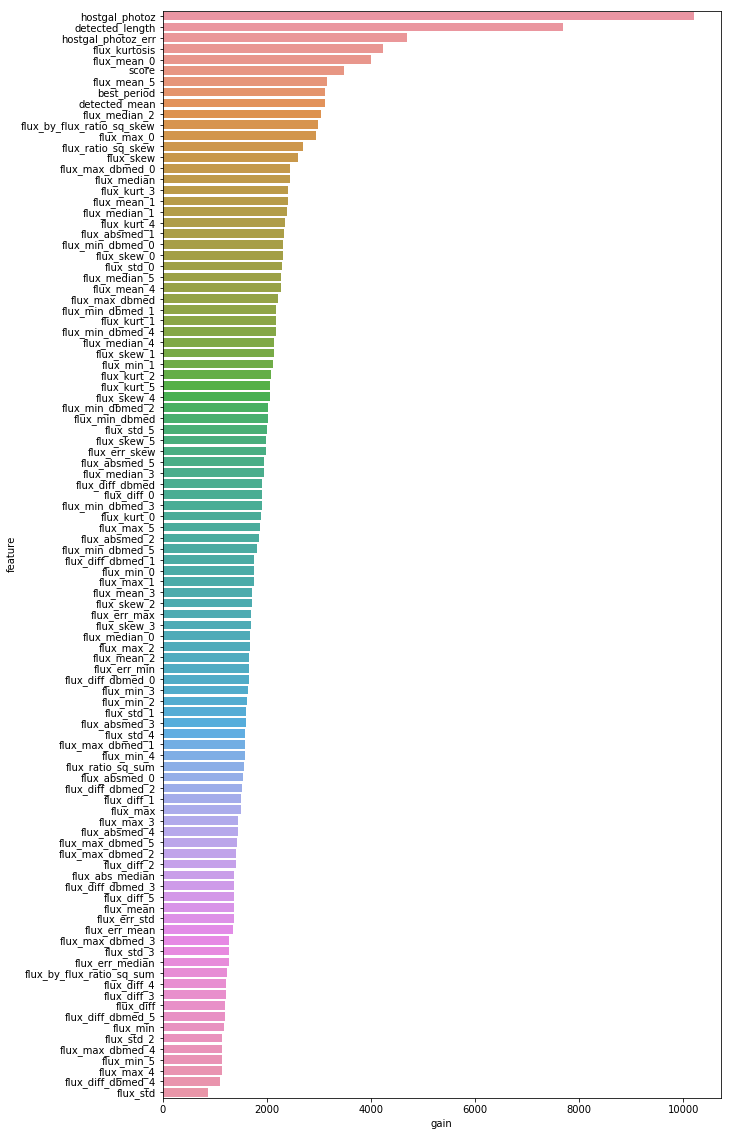

In [23]:
plt.figure(figsize=(10, 20))
sns.barplot(x='gain', y='feature', data=gal_importances.sort_values('gain', ascending=False))

In [24]:
dump(gal_clf, '../models/ex_clf12201958.joblib')

['../models/ex_clf12201958.joblib']

In [ ]:
gal_clf = load('../models/gal_clf12201958.joblib')
ex_clf = load('../models/ex_clf12201958.joblib')
meta_data = pd.read_csv('../input/test_set_metadata.csv', usecols=['object_id', 'hostgal_photoz', 'hostgal_photoz_err'])


In [ ]:
%%time
submit_df_list = []
for i_split in range(100):
    print(i_split, time.ctime())
    raw_train_df = pd.read_csv(f'../proccesed-data/test_split_{i_split}.csv')

    train = raw_train_df.copy()
    detected_groups = train[train['detected'] == 1].groupby('object_id')
    detected_length = detected_groups['mjd'].max() - detected_groups['mjd'].min()
    del train

    df = raw_train_df.copy()

    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']

    flux_all_dict = {
        "flux": ["min", "max", "mean", "median", "std", "skew"],
        "flux_err": ['min', 'max', 'mean', 'median', 'std','skew'],
        "detected": ["mean"],
        'flux_ratio_sq':['sum','skew'],
        'flux_by_flux_ratio_sq':['sum','skew']
    }

    flux_all_feats = df.groupby('object_id').agg(flux_all_dict)
    new_columns = [
        k + '_' + agg for k in flux_all_dict.keys() for agg in flux_all_dict[k]
    ]
    flux_all_feats.columns = new_columns

    flux_all_feats['detected_length'] = detected_length
    del detected_length

    flux_kurt = df.groupby('object_id').flux.apply(lambda x: x.kurtosis())
    flux_all_feats['flux_kurtosis'] = flux_kurt

    flux_all_feats[
        'flux_diff'] = flux_all_feats['flux_max'] - flux_all_feats['flux_min']

    flux_all_feats['flux_abs_median'] = df.groupby('object_id').flux.apply(
        lambda x: x.abs().median())

    flux_all_feats['flux_diff_dbmed'] = flux_all_feats[
        'flux_diff'] / flux_all_feats['flux_abs_median']
    flux_all_feats['flux_max_dbmed'] = flux_all_feats[
        'flux_max'] / flux_all_feats['flux_abs_median']
    flux_all_feats['flux_min_dbmed'] = flux_all_feats[
        'flux_min'] / flux_all_feats['flux_abs_median']

    flux_pb_feats = df.groupby(['object_id', 'passband']).agg({
        "flux": ["min", "max", "mean", "median", "std", "skew"],
    })

    flux_pb_feats.columns = [
        'flux_' + measure for measure in flux_pb_feats.columns.levels[1]
    ]

    flux_pb_kurt = df.groupby(['object_id',
                               'passband']).flux.apply(lambda x: x.kurtosis())
    flux_pb_absmed = df.groupby(
        ['object_id', 'passband']).flux.apply(lambda x: x.abs().median())

    concat_pd_feats = pd.concat([
        flux_pb_feats,
        pd.DataFrame({
            'flux_kurt': flux_pb_kurt
        }),
        pd.DataFrame({
            'flux_absmed': flux_pb_absmed
        })
    ],
                                axis=1)

    concat_pd_feats["flux_diff"] = concat_pd_feats[
        "flux_max"] - concat_pd_feats["flux_min"]
    concat_pd_feats["flux_diff_dbmed"] = concat_pd_feats[
        "flux_diff"] / concat_pd_feats['flux_absmed']
    concat_pd_feats["flux_max_dbmed"] = concat_pd_feats[
        "flux_max"] / concat_pd_feats['flux_absmed']
    concat_pd_feats["flux_min_dbmed"] = concat_pd_feats[
        "flux_min"] / concat_pd_feats['flux_absmed']

    flat_concat_pd_feats = concat_pd_feats.unstack()
    flat_concat_pd_feats.columns = [
        key + "_" + str(pb) for key in flat_concat_pd_feats.columns.levels[0]
        for pb in flat_concat_pd_feats.columns.levels[1]
    ]

    train_feature_df = pd.concat([flux_all_feats, flat_concat_pd_feats], axis=1)



    period_df = pd.read_csv(
        f'../proccesed-data/test_periods_split{i_split}.csv')

    period_df.index = period_df.object_id
    period_df.drop(columns=['object_id'], inplace=True)

    concat_df = pd.concat([train_feature_df, period_df], axis=1)
    meta_data.index = meta_data.object_id

    meta_concat_df = pd.concat([concat_df, meta_data[['hostgal_photoz', 'hostgal_photoz_err']]], axis=1)

    meta_concat_df.fillna(meta_concat_df.mean(), inplace=True)

    gal_df, ex_df = load_data.cut_galaxy(meta_concat_df,
                                             meta_data.loc[meta_concat_df.index])

    # n1-standard-8 では 8min44s
    # hicpu-32で1min35
    submit_df = submit.submit_scv(gal_clf, ex_clf, gal_df, ex_df)
    submit.write_submit_unknown_onehot(submit_df, 'test_result_12201958_{}'.format(i_split))


0 Mon Dec 17 12:55:17 2018
1 Mon Dec 17 13:01:01 2018
2 Mon Dec 17 13:06:25 2018
3 Mon Dec 17 13:11:46 2018
4 Mon Dec 17 13:17:11 2018
5 Mon Dec 17 13:22:41 2018
6 Mon Dec 17 13:28:04 2018
7 Mon Dec 17 13:33:27 2018
8 Mon Dec 17 13:38:47 2018
9 Mon Dec 17 13:44:08 2018
10 Mon Dec 17 13:49:33 2018
11 Mon Dec 17 13:54:59 2018
12 Mon Dec 17 14:00:22 2018
13 Mon Dec 17 14:05:49 2018
14 Mon Dec 17 14:11:12 2018


In [35]:
'test_result_12201958_{}'.format(i_split)

'test_result_12201958_99'

In [34]:
f'test_result_12201958_{i}'

'test_result_12201958_28'

In [31]:
submit_df = pd.read_csv('../results/test_')

FileNotFoundError: File b'../results/test_result_12201958_0_raw_proba.csv' does not exist